# Overturning circulation in PanAnt


In [1]:
%matplotlib inline
import cosima_cookbook as cc
from dask.distributed import Client
import matplotlib.pyplot as plt

In [2]:
db='panant.db'
session=cc.database.create_session(db)

In [3]:
client = Client(n_workers=6)
client

Client Scheduler: tcp://127.0.0.1:46709 Dashboard: /proxy/8787/status,Cluster Workers: 6 Cores: 48 Memory: 202.48 GB


**Note that chunking seems to be non-existent on MOM6 output files, so we need to specify chunking ourselves...**

Here we load meridional transport that has been calculated in density space, and sum vertically to create a streamfunction.

In [5]:
vmo = cc.querying.getvar('panan', 'vmo', session, chunks={'yq':60})

In [6]:
vmo

,Array,Chunk
Bytes,201.13 GB,725.76 MB
Shape,"(59, 70, 1691, 7200)","(6, 70, 60, 7200)"
Count,590 Tasks,290 Chunks
Type,float32,numpy.ndarray


In [7]:
vmosum = vmo.mean('time').sum('xh').load()/1e9

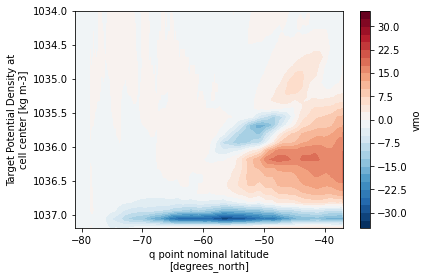

In [8]:
vmosum.cumsum('rho2_l').plot.contourf(levels=30)
plt.ylim([1034,1037.2])
plt.gca().invert_yaxis()

**Streamfunction is reasonable, and is well-resolved by this output format.**

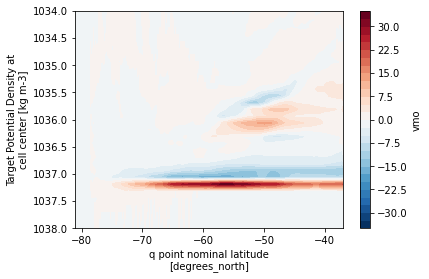

In [23]:
vmosum.plot.contourf(levels=30)
plt.ylim([1034,1037.5])
plt.gca().invert_yaxis()

**The above plot shows transport in each density class -- note northward in most dense layer, and southward transport at mid-depth.**

Code below is an attempt to play around with the density structure of the model. Probably needs a longer equilibration time to make this relevant.

In [11]:
hmo = cc.querying.getvar('panan', 'hmo', session,chunks={'yh':60})

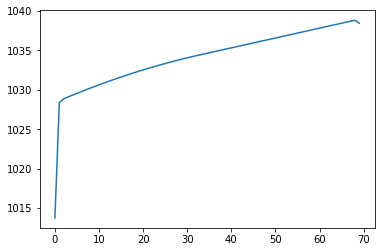

In [30]:
plt.plot(vmo.rho2_l.values)

**Problem with `rho2_l` axis??**

This axis is not monotonic. Means I can't use `sel` on this axis -- using `isel` instead. Selecting layer with `rho2_l = 1037.18641401`

In [57]:
hmo.rho2_l[55]

<xarray.DataArray 'rho2_l' ()>
array(1037.18641401)
Coordinates:
    rho2_l   float64 1.037e+03
Attributes:
    units:      kg m-3
    long_name:  Target Potential Density at cell center
    axis:       Z
    positive:   down
    edges:      rho2_i

In [55]:
hmopaths = hmo.mean('time').isel(rho2_l=55).load()

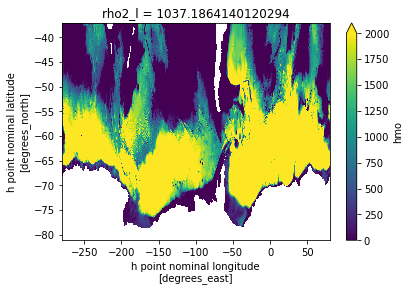

In [61]:
hmopaths.plot(vmax=2000)

Text(0.5, 1.0, 'layer thickness')

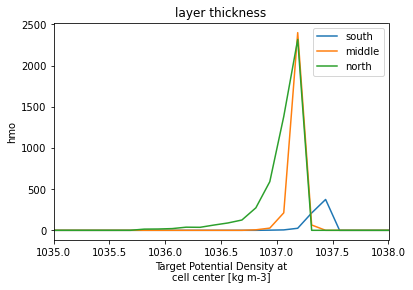

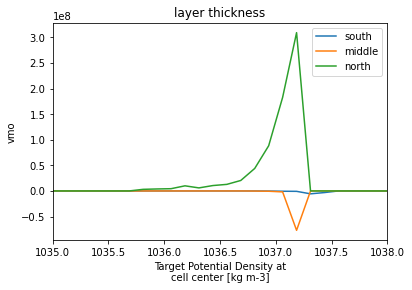

In [65]:
hmo.sel(xh=-190.0,method='nearest').sel(yh=-76,method='nearest').mean('time').plot(xlim=[1035,1038],label='south')
hmo.sel(xh=-190.0,method='nearest').sel(yh=-70,method='nearest').mean('time').plot(xlim=[1035,1038],label='middle')
hmo.sel(xh=-190.0,method='nearest').sel(yh=-60,method='nearest').mean('time').plot(xlim=[1035,1038],label='north')
plt.legend()
plt.title('layer thickness')
plt.figure()
vmo.sel(xh=-190.0,method='nearest').sel(yq=-76,method='nearest').mean('time').plot(xlim=[1035,1038],label='south')
vmo.sel(xh=-190.0,method='nearest').sel(yq=-70,method='nearest').mean('time').plot(xlim=[1035,1038],label='middle')
vmo.sel(xh=-190.0,method='nearest').sel(yq=-60,method='nearest').mean('time').plot(xlim=[1035,1038],label='north')
plt.legend()
plt.title('layer thickness')